cross entropy loss　分類問題

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更してね。

In [3]:
%cd "ctorch210824/MiniCTorch_Prototype"

/content/drive/My Drive/Colab Notebooks/ctorch210824/MiniCTorch_Prototype


In [4]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 5.8 MB/s 


In [5]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch
import minictorch.generator as GN
import minictorch.converter as CV

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

データ読み込み

In [7]:
# データ読み込み
iris = datasets.load_iris()
data   = iris['data']
target = iris['target']

# 学習データと検証データに分割
x_train, x_valid, y_train, y_valid = train_test_split( data, target, shuffle=True )

# 特徴量の標準化
scaler = StandardScaler()
scaler.fit( x_train )

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

# Tensor型に変換
# 学習に入れるときはfloat型 or long型になっている必要があるのここで変換してしまう
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid).long()

#print('x_train : ', x_train.shape)
#print('y_train : ', y_train.shape)
#print('x_valid : ', x_valid.shape)
#print('y_valid : ', y_valid.shape)

DataSetとDataLoaderの生成

In [8]:
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)

# indexを指定すればデータを取り出すことができます。
index = 0
print( train_dataset.__getitem__(index)[0].size() )
print( train_dataset.__getitem__(index)[1] )


batch_size = 112
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 動作確認
# こんな感じでバッチ単位で取り出す子ができます。
# イテレータに変換
batch_iterator = iter(train_dataloader)

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels.size())
print(inputs)
print(labels)

torch.Size([4])
tensor(1)
torch.Size([112, 4])
torch.Size([112])
tensor([[-1.0889, -1.4458, -0.2520, -0.2455],
        [-0.0264, -0.7616,  0.1996, -0.2455],
        [-1.4431,  0.3788, -1.3244, -1.3032],
        [ 0.4459, -1.9020,  0.4253,  0.4155],
        [-0.3805, -1.4458,  0.0302, -0.1133],
        [ 0.0917, -0.0774,  0.2560,  0.4155],
        [-0.9708, -0.0774, -1.2115, -1.3032],
        [ 1.1543,  0.3788,  1.2155,  1.4732],
        [ 1.6265, -0.0774,  1.1591,  0.5477],
        [ 1.0362, -1.2178,  1.1591,  0.8121],
        [-1.6792,  0.3788, -1.3808, -1.3032],
        [ 0.8001,  0.3788,  0.7640,  1.0766],
        [-0.8528,  1.7472, -1.2115, -1.3032],
        [-0.8528,  1.5191, -1.2679, -1.0388],
        [-1.4431,  0.1507, -1.2679, -1.3032],
        [-0.8528,  0.8349, -1.2679, -1.3032],
        [ 1.0362,  0.1507,  1.0462,  1.6054],
        [-1.4431,  0.8349, -1.3244, -1.1710],
        [-1.2070,  0.8349, -1.0422, -1.3032],
        [-0.1444, -0.5335,  0.1996,  0.1511],
        [ 0.209

ニューラルネットワークの定義

In [9]:
class Net(nn.Module):    
    def __init__(self,t):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 3)
        self.target = t
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = F.log_softmax(x, dim=1)
        #return x
        
        #print(x);
        #print(self.target);
        
        self.out = x

        loss = nn.CrossEntropyLoss()
        #loss = nn.NLLLoss()
        output = loss(x,self.target)
        return output
        

class Net2(nn.Module):    
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 3)
        #self.fc1 = nn.Linear(4, 128)
        #self.fc2 = nn.Linear(128, 3)
        #self.fc3 = nn.Linear(64, 3)
        #self.fc4 = nn.Linear(128, 3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc2(x)
        #x = F.softmax(x, dim=1)
        return x

In [10]:
def generate_json( json_path, input, target ):

    model = Net( target )
    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [11]:
torch.manual_seed( 1 )

print("inputs",inputs)
print("target",labels)
inputs.requires_grad = True

project = 'cse1'
json_path = 'network/' + project +'.json'

model = generate_json( json_path, inputs, labels )

with torch.set_grad_enabled(True):

  output = model( inputs )
  print("output",output)

  model.zero_grad()
  #torch.zeros_like(inputs.grad)

  output.backward()
  print("output grad",output.grad)
  #print("fc1 grad",model.fc1.weight.grad)
  #print("fc2 grad",model.fc2.weight.grad)
  print("input grad",inputs.grad)

  # ラベルを予測
  #print("output", model.out, inputs.size(0))
  _, preds = torch.max( model.out, 1 )

  # イテレーション結果の計算
  epoch_loss = output * inputs.size(0)

  # 正解数の合計を更新
  epoch_corrects = torch.sum( preds == labels.data )

  epoch_loss = epoch_loss / float(inputs.size(0))
  epoch_acc  = epoch_corrects.double() / float(inputs.size(0))

  epoch=1
  print('Train Loss {}: {:.4f} Acc: {:.4f}'.format( epoch, epoch_loss, epoch_acc ))

inputs tensor([[-1.0889, -1.4458, -0.2520, -0.2455],
        [-0.0264, -0.7616,  0.1996, -0.2455],
        [-1.4431,  0.3788, -1.3244, -1.3032],
        [ 0.4459, -1.9020,  0.4253,  0.4155],
        [-0.3805, -1.4458,  0.0302, -0.1133],
        [ 0.0917, -0.0774,  0.2560,  0.4155],
        [-0.9708, -0.0774, -1.2115, -1.3032],
        [ 1.1543,  0.3788,  1.2155,  1.4732],
        [ 1.6265, -0.0774,  1.1591,  0.5477],
        [ 1.0362, -1.2178,  1.1591,  0.8121],
        [-1.6792,  0.3788, -1.3808, -1.3032],
        [ 0.8001,  0.3788,  0.7640,  1.0766],
        [-0.8528,  1.7472, -1.2115, -1.3032],
        [-0.8528,  1.5191, -1.2679, -1.0388],
        [-1.4431,  0.1507, -1.2679, -1.3032],
        [-0.8528,  0.8349, -1.2679, -1.3032],
        [ 1.0362,  0.1507,  1.0462,  1.6054],
        [-1.4431,  0.8349, -1.3244, -1.1710],
        [-1.2070,  0.8349, -1.0422, -1.3032],
        [-0.1444, -0.5335,  0.1996,  0.1511],
        [ 0.2098, -0.7616,  0.7640,  0.5477],
        [ 0.6820,  0.1507, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.


In [12]:
"""
def convert_json( project, folder, model, input_x, json_path, rand_flag=0 ):

    #folder = "src"
    cpp_fname   = project + ".cpp"
    param_fname = project + "_param.cpp"
    cpp_path    = folder + "/" + cpp_fname
    param_path  = folder + "/" + param_fname
    make_path   = folder + "/" + "Makefile"

    # load json file
    print( "[JSON]", json_path )
    fp = open( json_path )
    obj = json.load( fp )

    # save parameter file
    code1 = CV.c_param_generator( obj, model, input_x )
    if len( code1 ) > 0:
       print( "[PARAM]", param_path )
       ofparam = open( param_path, "w" )
       ofparam.write( code1 )

    # save cpp file
    print( "[CPP]  ", cpp_path )
    code2 = CV.c_code_generator( obj, model, rand_flag )

    #ofp=open(args.path+"/"+args.output,"w")
    ofp = open( cpp_path, "w" )
    ofp.write( code2 )

    # save make file
    print( "[MAKE] ", make_path )
    make_code = CV.makefile_generator( cpp_fname )

    #makefp=open(args.path+"/"+"Makefile","w")
    makefp = open( make_path, "w" )
    makefp.write( make_code )
"""
CV.convert_json( project, "src", model, inputs, json_path )

[JSON] network/cse1.json
{'name': 'Net/Linear[fc1]/weight/35', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Net/Linear[fc1]/bias/34', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Net/Linear[fc2]/weight/38', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Net/Linear[fc2]/bias/37', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [7], 'sorted_id': 6}
[PARAM] src/cse1_param.cpp
{'name': 'input/x', 'op': 'IO Node', 'in': [], 'shape': [112, 4], 'out': [3], 'sorted_id': 0}
{'name': 'Net/Linear[fc1]/weight/35', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [3], 'sorted_id': 1}
Net/Linear[fc1]/weight/35  ->  fc1_weight
{'name': 'Net/Linear[fc1]/bias/34', 'op': 'prim::GetAttr', 'in': [], 'shape': [], 'out': [3], 'sorted_id': 2}
Net/Linear[fc1]/bias/34  ->  fc1_bias
{'name': 'Net/Linear[fc1]/input.1', 'op': 'aten::linear', 'in': [0, 1, 2], 'shape': [112, 64], 'out': [4], '

In [13]:
!g++ -std=c++14 ./src/cse1.cpp ./src/cse1_param.cpp -I ../../ctorch/lib -lblas -o ./bin/cse1

(注意) ctorch/libにxtensor関連のincludeを置いています。

In [14]:
!./bin/cse1

### forward computation ...
ashape1123
 1.159395
### backward computation ...
input_grad{{ 0.00082 , -0.000603,  0.00139 ,  0.000559},
 { 0.001123, -0.000081,  0.001604,  0.000121},
 {-0.001463, -0.000601,  0.000422, -0.000325},
 {-0.000266,  0.000936,  0.000065,  0.00013 },
 { 0.000381,  0.000362,  0.00097 ,  0.000006},
 { 0.000191, -0.000598,  0.0002  , -0.001294},
 {-0.001347, -0.000554,  0.000254, -0.000271},
 { 0.000442,  0.001073, -0.000085,  0.000649},
 { 0.001358,  0.001022, -0.000177,  0.00002 },
 { 0.001204,  0.000644, -0.000928,  0.00071 },
 {-0.001356, -0.000424,  0.000375, -0.000469},
 { 0.000642,  0.000732, -0.000637,  0.000665},
 {-0.001471,  0.000328,  0.000367,  0.000352},
 {-0.001323, -0.000004,  0.00001 ,  0.000292},
 {-0.001307, -0.000455,  0.000407, -0.000461},
 {-0.001503, -0.000642,  0.000117, -0.000173},
 { 0.000308,  0.001088, -0.000145,  0.000714},
 {-0.001357, -0.000466,  0.000502, -0.000483},
 {-0.001619, -0.000506, -0.000102, -0.000042},
 { 0.000541, -0.000

In [ ]:
torch.manual_seed( 1 )

#print("target",target)
inputs.requires_grad = True

#model = Net( labels )
model = Net2()

num = inputs.size(0)

project = 'test5'
#json_path = 'network/' + project +'.json'

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( model.parameters(), lr=0.01 )

num_epochs = 300

acc = []

for epoch in range(num_epochs):
  with torch.set_grad_enabled(True):

    model.train()   # モデルを訓練モードに設定

    outputs = model( inputs )
    #print(outputs)
    #print(labels)

    #print("input grad",inputs.grad)

    loss = criterion( outputs, labels )
    print("loss ",epoch, " - ",loss)

    # ラベルを予測
    #print("output", outputs, num )
    _, preds = torch.max( outputs, 1 )
    #print(labels)
    #print(preds)

    optimizer.zero_grad()

    # 逆伝搬の計算
    loss.backward()
                    
    # パラメータの更新
    optimizer.step()

    # イテレーション結果の計算
    epoch_loss = loss.item() * float(num)

    # 正解数の合計を更新
    epoch_corrects = torch.sum( preds == labels )

    epoch_loss = epoch_loss / float(num)
    epoch_acc  = epoch_corrects.double() / float(num)
    print('Train Loss {}: {:.4f} Acc: {:.4f} {}'.format( epoch, epoch_loss, epoch_acc, epoch_corrects ))

    acc.append( epoch_acc )

loss  0  -  tensor(1.1457, grad_fn=<NllLossBackward>)
Train Loss 0: 1.1457 Acc: 0.2054 23
loss  1  -  tensor(1.1206, grad_fn=<NllLossBackward>)
Train Loss 1: 1.1206 Acc: 0.2321 26
loss  2  -  tensor(1.0965, grad_fn=<NllLossBackward>)
Train Loss 2: 1.0965 Acc: 0.2232 25
loss  3  -  tensor(1.0735, grad_fn=<NllLossBackward>)
Train Loss 3: 1.0735 Acc: 0.2321 26
loss  4  -  tensor(1.0514, grad_fn=<NllLossBackward>)
Train Loss 4: 1.0514 Acc: 0.2500 28
loss  5  -  tensor(1.0303, grad_fn=<NllLossBackward>)
Train Loss 5: 1.0303 Acc: 0.2500 28
loss  6  -  tensor(1.0101, grad_fn=<NllLossBackward>)
Train Loss 6: 1.0101 Acc: 0.2679 30
loss  7  -  tensor(0.9907, grad_fn=<NllLossBackward>)
Train Loss 7: 0.9907 Acc: 0.3036 34
loss  8  -  tensor(0.9722, grad_fn=<NllLossBackward>)
Train Loss 8: 0.9722 Acc: 0.4286 48
loss  9  -  tensor(0.9545, grad_fn=<NllLossBackward>)
Train Loss 9: 0.9545 Acc: 0.4732 53
loss  10  -  tensor(0.9376, grad_fn=<NllLossBackward>)
Train Loss 10: 0.9376 Acc: 0.5268 59
loss  11

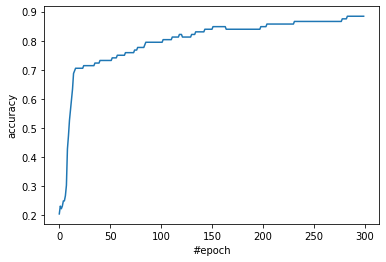

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(acc))),acc )
ax.set_xlabel('#epoch')
ax.set_ylabel('accuracy')
fig.show()

C++のコードは手作業で修正しています。

In [ ]:
!g++ -std=c++14 ./src/cse1_opt.cpp ./src/cse1_param.cpp -I ../../ctorch/lib -lblas -o ./bin/cse1_opt

In [ ]:
!./bin/cse1_opt

### forward computation ...
ashape1123
get_classes
epoch 0 - loss 1.16189 - accuracy 0.151786
### backward computation ...
### forward computation ...
ashape1123
get_classes
epoch 1 - loss 1.13564 - accuracy 0.151786
### backward computation ...
### forward computation ...
ashape1123
get_classes
epoch 2 - loss 1.11045 - accuracy 0.142857
### backward computation ...
### forward computation ...
ashape1123
get_classes
epoch 3 - loss 1.08629 - accuracy 0.151786
### backward computation ...
### forward computation ...
ashape1123
get_classes
epoch 4 - loss 1.06314 - accuracy 0.169643
### backward computation ...
### forward computation ...
ashape1123
get_classes
epoch 5 - loss 1.04096 - accuracy 0.169643
### backward computation ...
### forward computation ...
ashape1123
get_classes
epoch 6 - loss 1.01971 - accuracy 0.214286
### backward computation ...
### forward computation ...
ashape1123
get_classes
epoch 7 - loss 0.999362 - accuracy 0.276786
### backward computation ...
### forward com

In [ ]:
f = open('./cse1.out', 'r')

loss = []
acc=[]

datalist = f.readlines()
for data in datalist:
  #print(data)
  ds = data.split(',')
  loss.append( float(ds[0]) )
  acc.append( float(ds[1]) )

f.close()

print("epoch =", len(loss))
print( loss )

epoch = 300
[1.161893, 1.13564, 1.110451, 1.086295, 1.06314, 1.040958, 1.01971, 0.999362, 0.979881, 0.961233, 0.943388, 0.926308, 0.909962, 0.894315, 0.879338, 0.864998, 0.851266, 0.838112, 0.825509, 0.81343, 0.801849, 0.790739, 0.780077, 0.769839, 0.760005, 0.750553, 0.741464, 0.732719, 0.7243, 0.71619, 0.708374, 0.700835, 0.693561, 0.686537, 0.679752, 0.673194, 0.66685, 0.660711, 0.654765, 0.649004, 0.643418, 0.638, 0.632741, 0.627634, 0.622672, 0.617848, 0.613156, 0.60859, 0.604144, 0.599813, 0.595593, 0.591477, 0.587463, 0.583544, 0.579718, 0.57598, 0.572327, 0.568756, 0.565263, 0.561845, 0.5585, 0.555224, 0.552016, 0.548871, 0.54579, 0.542768, 0.539803, 0.536895, 0.53404, 0.531238, 0.528486, 0.525783, 0.523127, 0.520516, 0.517949, 0.515425, 0.512942, 0.510499, 0.508096, 0.50573, 0.503401, 0.501108, 0.498849, 0.496624, 0.494431, 0.49227, 0.490141, 0.488041, 0.485971, 0.48393, 0.481916, 0.47993, 0.477971, 0.476037, 0.474128, 0.472244, 0.470384, 0.468547, 0.466734, 0.464943, 0.463174

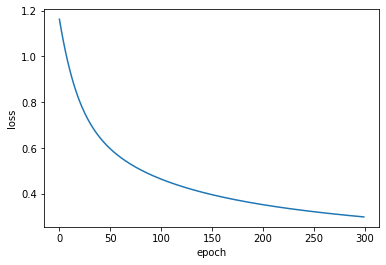

In [ ]:
# 交差エントロピー誤差
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(loss))), loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

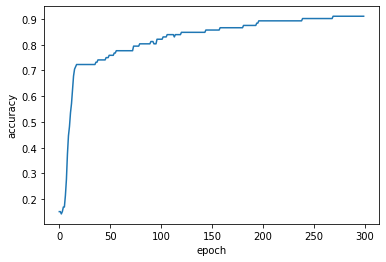

In [ ]:
# 正解率
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(acc))), acc)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.show()